In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import re
import string
import requests
import numpy as np
import collections
import random
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

# Start a session
sess = tf.Session()

print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['shakespeare.txt']


In [11]:

# Set RNN Parameters
min_word_freq = 5  # Trim the less frequent words off
rnn_size = 128  # RNN Model size
epochs = 150  # Number of epochs to cycle through data
batch_size = 100  # Train on this many examples at once
learning_rate = 0.001  # Learning rate
training_seq_len = 50  # how long of a word group to consider
embedding_size = rnn_size  # Word embedding size
save_every = 500  # How often to save model checkpoints
eval_every = 50  # How often to evaluate the test sentences
prime_texts = ['thou art more', 'to be or not to', 'wherefore art thou']

In [12]:

# Declare punctuation to remove, everything except hyphens and apostrophes
punctuation = string.punctuation
punctuation = ''.join([x for x in punctuation if x not in ['-', "'"]])

data_dir = 'temp'
data_file = 'shakespeare.txt'
model_path = 'shakespeare_model'
full_model_dir = os.path.join(data_dir, model_path)

print('Loading Shakespeare Data')
# Check if file is downloaded.
shakespear_file = '../input/shakespeare.txt'

with open(shakespear_file, 'r') as shakespear_file:
    s_text = shakespear_file.read()
    # Drop first few descriptive paragraphs.
    s_text = s_text[7675:]
    # Remove newlines
    s_text = s_text.replace('\r\n', '')
    s_text = s_text.replace('\n', '')
    
print('Cleaning Text')
s_text = re.sub(r'[{}]'.format(punctuation), ' ', s_text)
s_text = re.sub('\s+', ' ', s_text).strip().lower()


# Build word vocabulary function
def build_vocab(text, min_freq):
    word_counts = collections.Counter(text.split(' '))
    # limit word counts to those more frequent than cutoff
    word_counts = {key: val for key, val in word_counts.items() if val > min_freq}
    # Create vocab --> index mapping
    words = word_counts.keys()
    vocab_to_ix_dict = {key: (i_x+1) for i_x, key in enumerate(words)}
    # Add unknown key --> 0 index
    vocab_to_ix_dict['unknown'] = 0
    # Create index --> vocab mapping
    ix_to_vocab_dict = {val: key for key, val in vocab_to_ix_dict.items()}
    
    return ix_to_vocab_dict, vocab_to_ix_dict


# Build Shakespeare vocabulary
print('Building Shakespeare Vocab')
ix2vocab, vocab2ix = build_vocab(s_text, min_word_freq)
vocab_size = len(ix2vocab) + 1
print('Vocabulary Length = {}'.format(vocab_size))
# Sanity Check
assert(len(ix2vocab) == len(vocab2ix))


Loading Shakespeare Data
Cleaning Text
Building Shakespeare Vocab
Vocabulary Length = 7999


In [13]:

# Convert text to word vectors
s_text_words = s_text.split(' ')
s_text_ix = []
for ix, x in enumerate(s_text_words):
    try:
        s_text_ix.append(vocab2ix[x])
    except KeyError:
        s_text_ix.append(0)
s_text_ix = np.array(s_text_ix)


In [14]:

# Define LSTM RNN Model
class LSTM_Model():
    def __init__(self, embedding_size, rnn_size, batch_size, learning_rate,
                 training_seq_len, vocab_size, infer_sample=False):
        self.embedding_size = embedding_size
        self.rnn_size = rnn_size
        self.vocab_size = vocab_size
        self.infer_sample = infer_sample
        self.learning_rate = learning_rate
        
        if infer_sample:
            self.batch_size = 1
            self.training_seq_len = 1
        else:
            self.batch_size = batch_size
            self.training_seq_len = training_seq_len
        
        self.lstm_cell = tf.contrib.rnn.BasicLSTMCell(self.rnn_size)
        self.initial_state = self.lstm_cell.zero_state(self.batch_size, tf.float32)
        
        self.x_data = tf.placeholder(tf.int32, [self.batch_size, self.training_seq_len])
        self.y_output = tf.placeholder(tf.int32, [self.batch_size, self.training_seq_len])
        
        with tf.variable_scope('lstm_vars'):
            # Softmax Output Weights
            W = tf.get_variable('W', [self.rnn_size, self.vocab_size], tf.float32, tf.random_normal_initializer())
            b = tf.get_variable('b', [self.vocab_size], tf.float32, tf.constant_initializer(0.0))
        
            # Define Embedding
            embedding_mat = tf.get_variable('embedding_mat', [self.vocab_size, self.embedding_size],
                                            tf.float32, tf.random_normal_initializer())
                                            
            embedding_output = tf.nn.embedding_lookup(embedding_mat, self.x_data)
            rnn_inputs = tf.split(axis=1, num_or_size_splits=self.training_seq_len, value=embedding_output)
            rnn_inputs_trimmed = [tf.squeeze(x, [1]) for x in rnn_inputs]
        
        # If we are inferring (generating text), we add a 'loop' function
        # Define how to get the i+1 th input from the i th output
        def inferred_loop(prev):
            # Apply hidden layer
            prev_transformed = tf.matmul(prev, W) + b
            # Get the index of the output (also don't run the gradient)
            prev_symbol = tf.stop_gradient(tf.argmax(prev_transformed, 1))
            # Get embedded vector
            out = tf.nn.embedding_lookup(embedding_mat, prev_symbol)
            return out
        
        decoder = tf.contrib.legacy_seq2seq.rnn_decoder
        outputs, last_state = decoder(rnn_inputs_trimmed,
                                      self.initial_state,
                                      self.lstm_cell,
                                      loop_function=inferred_loop if infer_sample else None)
        # Non inferred outputs
        output = tf.reshape(tf.concat(axis=1, values=outputs), [-1, self.rnn_size])
        # Logits and output
        self.logit_output = tf.matmul(output, W) + b
        self.model_output = tf.nn.softmax(self.logit_output)
        
        loss_fun = tf.contrib.legacy_seq2seq.sequence_loss_by_example
        loss = loss_fun([self.logit_output], [tf.reshape(self.y_output, [-1])],
                        [tf.ones([self.batch_size * self.training_seq_len])])
        self.cost = tf.reduce_sum(loss) / (self.batch_size * self.training_seq_len)
        self.final_state = last_state
        gradients, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tf.trainable_variables()), 4.5)
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))
        
    def sample(self, sess, words=ix2vocab, vocab=vocab2ix, num=10, prime_text='thou art'):
        state = sess.run(self.lstm_cell.zero_state(1, tf.float32))
        word_list = prime_text.split()
        for word in word_list[:-1]:
            x = np.zeros((1, 1))
            x[0, 0] = vocab[word]
            feed_dict = {self.x_data: x, self.initial_state: state}
            [state] = sess.run([self.final_state], feed_dict=feed_dict)

        out_sentence = prime_text
        word = word_list[-1]
        for n in range(num):
            x = np.zeros((1, 1))
            x[0, 0] = vocab[word]
            feed_dict = {self.x_data: x, self.initial_state: state}
            [model_output, state] = sess.run([self.model_output, self.final_state], feed_dict=feed_dict)
            sample = np.argmax(model_output[0])
            if sample == 0:
                break
            word = words[sample]
            out_sentence = out_sentence + ' ' + word
        return out_sentence

In [15]:

# Define LSTM Model
lstm_model = LSTM_Model(embedding_size, rnn_size, batch_size, learning_rate,
                        training_seq_len, vocab_size)

# Tell TensorFlow we are reusing the scope for the testing
with tf.variable_scope(tf.get_variable_scope(), reuse=True):
    test_lstm_model = LSTM_Model(embedding_size, rnn_size, batch_size, learning_rate,
                                 training_seq_len, vocab_size, infer_sample=True)


# Create model saver
saver = tf.train.Saver(tf.global_variables())

# Create batches for each epoch
num_batches = int(len(s_text_ix)/(batch_size * training_seq_len)) + 1
# Split up text indices into subarrays, of equal size
batches = np.array_split(s_text_ix, num_batches)
# Reshape each split into [batch_size, training_seq_len]
batches = [np.resize(x, [batch_size, training_seq_len]) for x in batches]

# Initialize all variables
init = tf.global_variables_initializer()
sess.run(init)


In [16]:

# Train model
train_loss = []
iteration_count = 1
for epoch in range(epochs):
    # Shuffle word indices
    random.shuffle(batches)
    # Create targets from shuffled batches
    targets = [np.roll(x, -1, axis=1) for x in batches]
    # Run a through one epoch
    print('Starting Epoch #{} of {}.'.format(epoch+1, epochs))
    # Reset initial LSTM state every epoch
    state = sess.run(lstm_model.initial_state)
    for ix, batch in enumerate(batches):
        training_dict = {lstm_model.x_data: batch, lstm_model.y_output: targets[ix]}
        c, h = lstm_model.initial_state
        training_dict[c] = state.c
        training_dict[h] = state.h
        
        temp_loss, state, _ = sess.run([lstm_model.cost, lstm_model.final_state, lstm_model.train_op],
                                       feed_dict=training_dict)
        train_loss.append(temp_loss)
        
        # Print status every 10 gens
        if iteration_count % 10 == 0:
            summary_nums = (iteration_count, epoch+1, ix+1, num_batches+1, temp_loss)
            print('Iteration: {}, Epoch: {}, Batch: {} out of {}, Loss: {:.2f}'.format(*summary_nums))
        
        # Save the model and the vocab
        #if iteration_count % save_every == 0:
            # Save model
            #model_file_name = 'shakespear_model'
            #saver.save(sess, model_file_name, global_step=iteration_count)
            #print('Model Saved To: {}'.format(model_file_name))
            # Save vocabulary
            #dictionary_file = os.path.join(full_model_dir, 'vocab.pkl')
            #with open(dictionary_file, 'wb') as dict_file_conn:
            #    pickle.dump([vocab2ix, ix2vocab], dict_file_conn)
        
        if iteration_count % eval_every == 0:
            for sample in prime_texts:
                print(test_lstm_model.sample(sess, ix2vocab, vocab2ix, num=10, prime_text=sample))
                
        iteration_count += 1


Starting Epoch #1 of 150.
Iteration: 10, Epoch: 1, Batch: 10 out of 181, Loss: 9.86
Iteration: 20, Epoch: 1, Batch: 20 out of 181, Loss: 9.19
Iteration: 30, Epoch: 1, Batch: 30 out of 181, Loss: 8.72
Iteration: 40, Epoch: 1, Batch: 40 out of 181, Loss: 8.50
Iteration: 50, Epoch: 1, Batch: 50 out of 181, Loss: 8.18
thou art more than pedlar
to be or not to the
wherefore art thou faith to the
Iteration: 60, Epoch: 1, Batch: 60 out of 181, Loss: 7.90
Iteration: 70, Epoch: 1, Batch: 70 out of 181, Loss: 7.64
Iteration: 80, Epoch: 1, Batch: 80 out of 181, Loss: 7.31
Iteration: 90, Epoch: 1, Batch: 90 out of 181, Loss: 7.37
Iteration: 100, Epoch: 1, Batch: 100 out of 181, Loss: 7.15
thou art more than i have a
to be or not to the
wherefore art thou
Iteration: 110, Epoch: 1, Batch: 110 out of 181, Loss: 6.87
Iteration: 120, Epoch: 1, Batch: 120 out of 181, Loss: 6.93
Iteration: 130, Epoch: 1, Batch: 130 out of 181, Loss: 6.92
Iteration: 140, Epoch: 1, Batch: 140 out of 181, Loss: 6.86
Iterati

Iteration: 1100, Epoch: 7, Batch: 20 out of 181, Loss: 5.75
thou art more than a
to be or not to the
wherefore art thou not
Iteration: 1110, Epoch: 7, Batch: 30 out of 181, Loss: 5.91
Iteration: 1120, Epoch: 7, Batch: 40 out of 181, Loss: 5.77
Iteration: 1130, Epoch: 7, Batch: 50 out of 181, Loss: 5.85
Iteration: 1140, Epoch: 7, Batch: 60 out of 181, Loss: 6.02
Iteration: 1150, Epoch: 7, Batch: 70 out of 181, Loss: 6.09
thou art more than a
to be or not to the
wherefore art thou not not
Iteration: 1160, Epoch: 7, Batch: 80 out of 181, Loss: 5.88
Iteration: 1170, Epoch: 7, Batch: 90 out of 181, Loss: 6.04
Iteration: 1180, Epoch: 7, Batch: 100 out of 181, Loss: 5.98
Iteration: 1190, Epoch: 7, Batch: 110 out of 181, Loss: 5.70
Iteration: 1200, Epoch: 7, Batch: 120 out of 181, Loss: 5.93
thou art more than a
to be or not to the
wherefore art thou not a
Iteration: 1210, Epoch: 7, Batch: 130 out of 181, Loss: 5.94
Iteration: 1220, Epoch: 7, Batch: 140 out of 181, Loss: 5.57
Iteration: 1230, 

Iteration: 2170, Epoch: 13, Batch: 10 out of 181, Loss: 5.82
Iteration: 2180, Epoch: 13, Batch: 20 out of 181, Loss: 5.53
Iteration: 2190, Epoch: 13, Batch: 30 out of 181, Loss: 5.70
Iteration: 2200, Epoch: 13, Batch: 40 out of 181, Loss: 5.23
thou art more than a
to be or not to the
wherefore art thou not
Iteration: 2210, Epoch: 13, Batch: 50 out of 181, Loss: 5.64
Iteration: 2220, Epoch: 13, Batch: 60 out of 181, Loss: 5.59
Iteration: 2230, Epoch: 13, Batch: 70 out of 181, Loss: 5.83
Iteration: 2240, Epoch: 13, Batch: 80 out of 181, Loss: 5.78
Iteration: 2250, Epoch: 13, Batch: 90 out of 181, Loss: 5.64
thou art more than a
to be or not to the
wherefore art thou not
Iteration: 2260, Epoch: 13, Batch: 100 out of 181, Loss: 5.43
Iteration: 2270, Epoch: 13, Batch: 110 out of 181, Loss: 5.58
Iteration: 2280, Epoch: 13, Batch: 120 out of 181, Loss: 5.67
Iteration: 2290, Epoch: 13, Batch: 130 out of 181, Loss: 5.74
Iteration: 2300, Epoch: 13, Batch: 140 out of 181, Loss: 5.65
thou art more

thou art more than a
to be or not to be
wherefore art thou not not thy
Iteration: 3210, Epoch: 18, Batch: 150 out of 181, Loss: 5.46
Iteration: 3220, Epoch: 18, Batch: 160 out of 181, Loss: 5.69
Iteration: 3230, Epoch: 18, Batch: 170 out of 181, Loss: 5.50
Iteration: 3240, Epoch: 18, Batch: 180 out of 181, Loss: 5.55
Starting Epoch #19 of 150.
Iteration: 3250, Epoch: 19, Batch: 10 out of 181, Loss: 5.64
thou art more than a
to be or not to be
wherefore art thou not not speak to me i will not hear thee
Iteration: 3260, Epoch: 19, Batch: 20 out of 181, Loss: 5.46
Iteration: 3270, Epoch: 19, Batch: 30 out of 181, Loss: 5.79
Iteration: 3280, Epoch: 19, Batch: 40 out of 181, Loss: 5.18
Iteration: 3290, Epoch: 19, Batch: 50 out of 181, Loss: 5.50
Iteration: 3300, Epoch: 19, Batch: 60 out of 181, Loss: 5.45
thou art more than a
to be or not to the
wherefore art thou not not thy
Iteration: 3310, Epoch: 19, Batch: 70 out of 181, Loss: 5.51
Iteration: 3320, Epoch: 19, Batch: 80 out of 181, Loss:

Iteration: 4230, Epoch: 24, Batch: 90 out of 181, Loss: 5.56
Iteration: 4240, Epoch: 24, Batch: 100 out of 181, Loss: 5.31
Iteration: 4250, Epoch: 24, Batch: 110 out of 181, Loss: 5.37
thou art more than thou art a
to be or not to be
wherefore art thou not not well i am not so i am a
Iteration: 4260, Epoch: 24, Batch: 120 out of 181, Loss: 5.31
Iteration: 4270, Epoch: 24, Batch: 130 out of 181, Loss: 5.26
Iteration: 4280, Epoch: 24, Batch: 140 out of 181, Loss: 5.26
Iteration: 4290, Epoch: 24, Batch: 150 out of 181, Loss: 5.47
Iteration: 4300, Epoch: 24, Batch: 160 out of 181, Loss: 5.34
thou art more than thou art a
to be or not to the
wherefore art thou not not well i am not so i am a
Iteration: 4310, Epoch: 24, Batch: 170 out of 181, Loss: 5.50
Iteration: 4320, Epoch: 24, Batch: 180 out of 181, Loss: 5.36
Starting Epoch #25 of 150.
Iteration: 4330, Epoch: 25, Batch: 10 out of 181, Loss: 5.30
Iteration: 4340, Epoch: 25, Batch: 20 out of 181, Loss: 5.33
Iteration: 4350, Epoch: 25, Bat

Iteration: 5250, Epoch: 30, Batch: 30 out of 181, Loss: 5.43
thou art more than thou art a
to be or not to be
wherefore art thou not not speak to me i will not hear it
Iteration: 5260, Epoch: 30, Batch: 40 out of 181, Loss: 5.45
Iteration: 5270, Epoch: 30, Batch: 50 out of 181, Loss: 5.41
Iteration: 5280, Epoch: 30, Batch: 60 out of 181, Loss: 5.30
Iteration: 5290, Epoch: 30, Batch: 70 out of 181, Loss: 5.26
Iteration: 5300, Epoch: 30, Batch: 80 out of 181, Loss: 5.38
thou art more than thou art a
to be or not to be
wherefore art thou not not speak to me i am a
Iteration: 5310, Epoch: 30, Batch: 90 out of 181, Loss: 5.13
Iteration: 5320, Epoch: 30, Batch: 100 out of 181, Loss: 5.37
Iteration: 5330, Epoch: 30, Batch: 110 out of 181, Loss: 5.06
Iteration: 5340, Epoch: 30, Batch: 120 out of 181, Loss: 5.34
Iteration: 5350, Epoch: 30, Batch: 130 out of 181, Loss: 5.39
thou art more than thou art a
to be or not to be
wherefore art thou not not distributed or usedcommercially prohibited comm

Iteration: 6220, Epoch: 35, Batch: 100 out of 181, Loss: 5.39
Iteration: 6230, Epoch: 35, Batch: 110 out of 181, Loss: 5.21
Iteration: 6240, Epoch: 35, Batch: 120 out of 181, Loss: 5.17
Iteration: 6250, Epoch: 35, Batch: 130 out of 181, Loss: 5.19
thou art more than thou art not to be
to be or not to be
wherefore art thou not not asham'd to me i will not hear it
Iteration: 6260, Epoch: 35, Batch: 140 out of 181, Loss: 5.01
Iteration: 6270, Epoch: 35, Batch: 150 out of 181, Loss: 5.38
Iteration: 6280, Epoch: 35, Batch: 160 out of 181, Loss: 5.31
Iteration: 6290, Epoch: 35, Batch: 170 out of 181, Loss: 5.31
Iteration: 6300, Epoch: 35, Batch: 180 out of 181, Loss: 5.30
thou art more than thou art a
to be or not to be
wherefore art thou not
Starting Epoch #36 of 150.
Iteration: 6310, Epoch: 36, Batch: 10 out of 181, Loss: 5.10
Iteration: 6320, Epoch: 36, Batch: 20 out of 181, Loss: 5.23
Iteration: 6330, Epoch: 36, Batch: 30 out of 181, Loss: 5.36
Iteration: 6340, Epoch: 36, Batch: 40 out o

Iteration: 7210, Epoch: 41, Batch: 10 out of 181, Loss: 5.04
Iteration: 7220, Epoch: 41, Batch: 20 out of 181, Loss: 5.21
Iteration: 7230, Epoch: 41, Batch: 30 out of 181, Loss: 5.17
Iteration: 7240, Epoch: 41, Batch: 40 out of 181, Loss: 4.98
Iteration: 7250, Epoch: 41, Batch: 50 out of 181, Loss: 5.12
thou art more than thou art a
to be or not to be
wherefore art thou not asham'd to me i am not so i am
Iteration: 7260, Epoch: 41, Batch: 60 out of 181, Loss: 5.17
Iteration: 7270, Epoch: 41, Batch: 70 out of 181, Loss: 5.23
Iteration: 7280, Epoch: 41, Batch: 80 out of 181, Loss: 5.01
Iteration: 7290, Epoch: 41, Batch: 90 out of 181, Loss: 4.93
Iteration: 7300, Epoch: 41, Batch: 100 out of 181, Loss: 4.97
thou art more than thou art a
to be or not to be
wherefore art thou not not asham'd to me i am not so much
Iteration: 7310, Epoch: 41, Batch: 110 out of 181, Loss: 5.21
Iteration: 7320, Epoch: 41, Batch: 120 out of 181, Loss: 4.97
Iteration: 7330, Epoch: 41, Batch: 130 out of 181, Loss

to be or not to be
wherefore art thou not asham'd to my lord i am not so i
Iteration: 8210, Epoch: 46, Batch: 110 out of 181, Loss: 5.15
Iteration: 8220, Epoch: 46, Batch: 120 out of 181, Loss: 4.90
Iteration: 8230, Epoch: 46, Batch: 130 out of 181, Loss: 5.11
Iteration: 8240, Epoch: 46, Batch: 140 out of 181, Loss: 5.08
Iteration: 8250, Epoch: 46, Batch: 150 out of 181, Loss: 4.97
thou art more than thou art a
to be or not to be
wherefore art thou not ashamed to me for my love i have a
Iteration: 8260, Epoch: 46, Batch: 160 out of 181, Loss: 5.11
Iteration: 8270, Epoch: 46, Batch: 170 out of 181, Loss: 5.43
Iteration: 8280, Epoch: 46, Batch: 180 out of 181, Loss: 5.23
Starting Epoch #47 of 150.
Iteration: 8290, Epoch: 47, Batch: 10 out of 181, Loss: 5.09
Iteration: 8300, Epoch: 47, Batch: 20 out of 181, Loss: 4.86
thou art more than thou art a
to be or not to be
wherefore art thou not asham'd to me i am not so much as
Iteration: 8310, Epoch: 47, Batch: 30 out of 181, Loss: 4.92
Iterat

thou art more than
to be or not to be
wherefore art thou not ashamed to me for my love i am not
Iteration: 9210, Epoch: 52, Batch: 30 out of 181, Loss: 5.04
Iteration: 9220, Epoch: 52, Batch: 40 out of 181, Loss: 4.77
Iteration: 9230, Epoch: 52, Batch: 50 out of 181, Loss: 5.12
Iteration: 9240, Epoch: 52, Batch: 60 out of 181, Loss: 5.02
Iteration: 9250, Epoch: 52, Batch: 70 out of 181, Loss: 4.99
thou art more than thou art a
to be or not to be
wherefore art thou not ashamed to me for my love and i will
Iteration: 9260, Epoch: 52, Batch: 80 out of 181, Loss: 4.80
Iteration: 9270, Epoch: 52, Batch: 90 out of 181, Loss: 5.12
Iteration: 9280, Epoch: 52, Batch: 100 out of 181, Loss: 4.96
Iteration: 9290, Epoch: 52, Batch: 110 out of 181, Loss: 4.85
Iteration: 9300, Epoch: 52, Batch: 120 out of 181, Loss: 4.88
thou art more than thou art a
to be or not to be
wherefore art thou villain wilt thou not be so
Iteration: 9310, Epoch: 52, Batch: 130 out of 181, Loss: 4.92
Iteration: 9320, Epoch: 

Iteration: 10220, Epoch: 57, Batch: 140 out of 181, Loss: 5.01
Iteration: 10230, Epoch: 57, Batch: 150 out of 181, Loss: 4.98
Iteration: 10240, Epoch: 57, Batch: 160 out of 181, Loss: 4.89
Iteration: 10250, Epoch: 57, Batch: 170 out of 181, Loss: 4.87
thou art more than thou art
to be or not to be
wherefore art thou villain thou art a
Iteration: 10260, Epoch: 57, Batch: 180 out of 181, Loss: 4.74
Starting Epoch #58 of 150.
Iteration: 10270, Epoch: 58, Batch: 10 out of 181, Loss: 4.88
Iteration: 10280, Epoch: 58, Batch: 20 out of 181, Loss: 5.15
Iteration: 10290, Epoch: 58, Batch: 30 out of 181, Loss: 5.24
Iteration: 10300, Epoch: 58, Batch: 40 out of 181, Loss: 5.08
thou art more than
to be or not to be
wherefore art thou villain wilt thou not be
Iteration: 10310, Epoch: 58, Batch: 50 out of 181, Loss: 4.89
Iteration: 10320, Epoch: 58, Batch: 60 out of 181, Loss: 5.04
Iteration: 10330, Epoch: 58, Batch: 70 out of 181, Loss: 4.99
Iteration: 10340, Epoch: 58, Batch: 80 out of 181, Loss: 

Iteration: 11250, Epoch: 63, Batch: 90 out of 181, Loss: 4.87
thou art more than
to be or not to be
wherefore art thou villain dost thou not
Iteration: 11260, Epoch: 63, Batch: 100 out of 181, Loss: 4.74
Iteration: 11270, Epoch: 63, Batch: 110 out of 181, Loss: 4.90
Iteration: 11280, Epoch: 63, Batch: 120 out of 181, Loss: 4.78
Iteration: 11290, Epoch: 63, Batch: 130 out of 181, Loss: 4.74
Iteration: 11300, Epoch: 63, Batch: 140 out of 181, Loss: 4.61
thou art more than a
to be or not to be
wherefore art thou villain wilt thou not be
Iteration: 11310, Epoch: 63, Batch: 150 out of 181, Loss: 5.25
Iteration: 11320, Epoch: 63, Batch: 160 out of 181, Loss: 4.90
Iteration: 11330, Epoch: 63, Batch: 170 out of 181, Loss: 4.81
Iteration: 11340, Epoch: 63, Batch: 180 out of 181, Loss: 4.90
Starting Epoch #64 of 150.
Iteration: 11350, Epoch: 64, Batch: 10 out of 181, Loss: 4.82
thou art more than
to be or not to be
wherefore art thou villain wilt thou not be
Iteration: 11360, Epoch: 64, Batch: 2

thou art more than
to be or not to be
wherefore art thou villain wilt thou not speak to me i am not
Iteration: 12260, Epoch: 69, Batch: 20 out of 181, Loss: 4.61
Iteration: 12270, Epoch: 69, Batch: 30 out of 181, Loss: 4.61
Iteration: 12280, Epoch: 69, Batch: 40 out of 181, Loss: 4.78
Iteration: 12290, Epoch: 69, Batch: 50 out of 181, Loss: 4.90
Iteration: 12300, Epoch: 69, Batch: 60 out of 181, Loss: 4.80
thou art more than
to be or not to be
wherefore art thou villain dost thou hadst been
Iteration: 12310, Epoch: 69, Batch: 70 out of 181, Loss: 4.72
Iteration: 12320, Epoch: 69, Batch: 80 out of 181, Loss: 4.88
Iteration: 12330, Epoch: 69, Batch: 90 out of 181, Loss: 4.93
Iteration: 12340, Epoch: 69, Batch: 100 out of 181, Loss: 4.75
Iteration: 12350, Epoch: 69, Batch: 110 out of 181, Loss: 4.79
thou art more than
to be or not to be
wherefore art thou villain dost thou not
Iteration: 12360, Epoch: 69, Batch: 120 out of 181, Loss: 4.83
Iteration: 12370, Epoch: 69, Batch: 130 out of 181

wherefore art thou villain wilt thou not be
Iteration: 13260, Epoch: 74, Batch: 120 out of 181, Loss: 4.80
Iteration: 13270, Epoch: 74, Batch: 130 out of 181, Loss: 4.79
Iteration: 13280, Epoch: 74, Batch: 140 out of 181, Loss: 4.87
Iteration: 13290, Epoch: 74, Batch: 150 out of 181, Loss: 4.79
Iteration: 13300, Epoch: 74, Batch: 160 out of 181, Loss: 5.02
thou art more than
to be or not to be
wherefore art thou villain dost thou hadst been
Iteration: 13310, Epoch: 74, Batch: 170 out of 181, Loss: 4.77
Iteration: 13320, Epoch: 74, Batch: 180 out of 181, Loss: 5.00
Starting Epoch #75 of 150.
Iteration: 13330, Epoch: 75, Batch: 10 out of 181, Loss: 4.40
Iteration: 13340, Epoch: 75, Batch: 20 out of 181, Loss: 4.87
Iteration: 13350, Epoch: 75, Batch: 30 out of 181, Loss: 4.89
thou art more than
to be or not to be
wherefore art thou villain dost thou hadst been
Iteration: 13360, Epoch: 75, Batch: 40 out of 181, Loss: 4.74
Iteration: 13370, Epoch: 75, Batch: 50 out of 181, Loss: 4.75
Iterat

Iteration: 14260, Epoch: 80, Batch: 40 out of 181, Loss: 4.42
Iteration: 14270, Epoch: 80, Batch: 50 out of 181, Loss: 4.66
Iteration: 14280, Epoch: 80, Batch: 60 out of 181, Loss: 5.00
Iteration: 14290, Epoch: 80, Batch: 70 out of 181, Loss: 4.75
Iteration: 14300, Epoch: 80, Batch: 80 out of 181, Loss: 4.66
thou art more than
to be or not to be
wherefore art thou villain dost thou hadst been
Iteration: 14310, Epoch: 80, Batch: 90 out of 181, Loss: 4.86
Iteration: 14320, Epoch: 80, Batch: 100 out of 181, Loss: 4.94
Iteration: 14330, Epoch: 80, Batch: 110 out of 181, Loss: 4.64
Iteration: 14340, Epoch: 80, Batch: 120 out of 181, Loss: 4.82
Iteration: 14350, Epoch: 80, Batch: 130 out of 181, Loss: 4.78
thou art more than
to be or not to be
wherefore art thou villain think'st thou thy husband and thy
Iteration: 14360, Epoch: 80, Batch: 140 out of 181, Loss: 4.81
Iteration: 14370, Epoch: 80, Batch: 150 out of 181, Loss: 4.61
Iteration: 14380, Epoch: 80, Batch: 160 out of 181, Loss: 4.70
It

wherefore art thou villain dost thou hadst been
Iteration: 15260, Epoch: 85, Batch: 140 out of 181, Loss: 4.68
Iteration: 15270, Epoch: 85, Batch: 150 out of 181, Loss: 4.68
Iteration: 15280, Epoch: 85, Batch: 160 out of 181, Loss: 4.67
Iteration: 15290, Epoch: 85, Batch: 170 out of 181, Loss: 4.73
Iteration: 15300, Epoch: 85, Batch: 180 out of 181, Loss: 4.70
thou art more than
to be or not to be
wherefore art thou villain wilt thou kill thy soul or thy
Starting Epoch #86 of 150.
Iteration: 15310, Epoch: 86, Batch: 10 out of 181, Loss: 4.53
Iteration: 15320, Epoch: 86, Batch: 20 out of 181, Loss: 4.83
Iteration: 15330, Epoch: 86, Batch: 30 out of 181, Loss: 4.75
Iteration: 15340, Epoch: 86, Batch: 40 out of 181, Loss: 4.75
Iteration: 15350, Epoch: 86, Batch: 50 out of 181, Loss: 4.75
thou art more than
to be or not to be
wherefore art thou villain think'st thou thy husband and thy
Iteration: 15360, Epoch: 86, Batch: 60 out of 181, Loss: 4.20
Iteration: 15370, Epoch: 86, Batch: 70 out 

wherefore art thou villain dost thou say the
Iteration: 16260, Epoch: 91, Batch: 60 out of 181, Loss: 4.50
Iteration: 16270, Epoch: 91, Batch: 70 out of 181, Loss: 4.54
Iteration: 16280, Epoch: 91, Batch: 80 out of 181, Loss: 4.56
Iteration: 16290, Epoch: 91, Batch: 90 out of 181, Loss: 4.63
Iteration: 16300, Epoch: 91, Batch: 100 out of 181, Loss: 4.73
thou art more than
to be or not to be
wherefore art thou villain dost thou hadst been
Iteration: 16310, Epoch: 91, Batch: 110 out of 181, Loss: 4.59
Iteration: 16320, Epoch: 91, Batch: 120 out of 181, Loss: 4.53
Iteration: 16330, Epoch: 91, Batch: 130 out of 181, Loss: 4.31
Iteration: 16340, Epoch: 91, Batch: 140 out of 181, Loss: 4.80
Iteration: 16350, Epoch: 91, Batch: 150 out of 181, Loss: 4.68
thou art more than
to be or not to be
wherefore art thou villain wast thou art a
Iteration: 16360, Epoch: 91, Batch: 160 out of 181, Loss: 4.77
Iteration: 16370, Epoch: 91, Batch: 170 out of 181, Loss: 4.91
Iteration: 16380, Epoch: 91, Batch: 

Iteration: 17260, Epoch: 96, Batch: 160 out of 181, Loss: 4.56
Iteration: 17270, Epoch: 96, Batch: 170 out of 181, Loss: 4.57
Iteration: 17280, Epoch: 96, Batch: 180 out of 181, Loss: 4.26
Starting Epoch #97 of 150.
Iteration: 17290, Epoch: 97, Batch: 10 out of 181, Loss: 4.23
Iteration: 17300, Epoch: 97, Batch: 20 out of 181, Loss: 4.45
thou art more than
to be or not to be
wherefore art thou villain dost thou hadst been
Iteration: 17310, Epoch: 97, Batch: 30 out of 181, Loss: 4.65
Iteration: 17320, Epoch: 97, Batch: 40 out of 181, Loss: 4.48
Iteration: 17330, Epoch: 97, Batch: 50 out of 181, Loss: 4.60
Iteration: 17340, Epoch: 97, Batch: 60 out of 181, Loss: 4.53
Iteration: 17350, Epoch: 97, Batch: 70 out of 181, Loss: 4.73
thou art more than
to be or not to be
wherefore art thou villain dost thou hadst been
Iteration: 17360, Epoch: 97, Batch: 80 out of 181, Loss: 4.45
Iteration: 17370, Epoch: 97, Batch: 90 out of 181, Loss: 4.39
Iteration: 17380, Epoch: 97, Batch: 100 out of 181, Lo

Iteration: 18240, Epoch: 102, Batch: 60 out of 181, Loss: 4.72
Iteration: 18250, Epoch: 102, Batch: 70 out of 181, Loss: 4.45
thou art more than
to be or not to be
wherefore art thou villain dost thou hadst been
Iteration: 18260, Epoch: 102, Batch: 80 out of 181, Loss: 4.40
Iteration: 18270, Epoch: 102, Batch: 90 out of 181, Loss: 4.50
Iteration: 18280, Epoch: 102, Batch: 100 out of 181, Loss: 4.65
Iteration: 18290, Epoch: 102, Batch: 110 out of 181, Loss: 4.41
Iteration: 18300, Epoch: 102, Batch: 120 out of 181, Loss: 4.82
thou art more than
to be or not to be
wherefore art thou villain dost thou hadst been
Iteration: 18310, Epoch: 102, Batch: 130 out of 181, Loss: 4.89
Iteration: 18320, Epoch: 102, Batch: 140 out of 181, Loss: 4.88
Iteration: 18330, Epoch: 102, Batch: 150 out of 181, Loss: 4.51
Iteration: 18340, Epoch: 102, Batch: 160 out of 181, Loss: 4.51
Iteration: 18350, Epoch: 102, Batch: 170 out of 181, Loss: 4.67
thou art more ugly than my
to be or not to be
wherefore art thou

Iteration: 19190, Epoch: 107, Batch: 110 out of 181, Loss: 4.51
Iteration: 19200, Epoch: 107, Batch: 120 out of 181, Loss: 4.67
thou art more ugly than word a word with thee thou
to be or not to be
wherefore art thou villain dost thou hadst been
Iteration: 19210, Epoch: 107, Batch: 130 out of 181, Loss: 4.43
Iteration: 19220, Epoch: 107, Batch: 140 out of 181, Loss: 4.44
Iteration: 19230, Epoch: 107, Batch: 150 out of 181, Loss: 4.48
Iteration: 19240, Epoch: 107, Batch: 160 out of 181, Loss: 4.57
Iteration: 19250, Epoch: 107, Batch: 170 out of 181, Loss: 4.85
thou art more ugly than word a word with me i am not
to be or not to be
wherefore art thou villain wast thou art a
Iteration: 19260, Epoch: 107, Batch: 180 out of 181, Loss: 4.61
Starting Epoch #108 of 150.
Iteration: 19270, Epoch: 108, Batch: 10 out of 181, Loss: 4.52
Iteration: 19280, Epoch: 108, Batch: 20 out of 181, Loss: 4.33
Iteration: 19290, Epoch: 108, Batch: 30 out of 181, Loss: 4.47
Iteration: 19300, Epoch: 108, Batch: 4

Iteration: 20120, Epoch: 112, Batch: 140 out of 181, Loss: 4.53
Iteration: 20130, Epoch: 112, Batch: 150 out of 181, Loss: 4.58
Iteration: 20140, Epoch: 112, Batch: 160 out of 181, Loss: 4.60
Iteration: 20150, Epoch: 112, Batch: 170 out of 181, Loss: 4.49
thou art more ugly than my
to be or not to be
wherefore art thou villain wast thou art a
Iteration: 20160, Epoch: 112, Batch: 180 out of 181, Loss: 4.46
Starting Epoch #113 of 150.
Iteration: 20170, Epoch: 113, Batch: 10 out of 181, Loss: 4.40
Iteration: 20180, Epoch: 113, Batch: 20 out of 181, Loss: 4.49
Iteration: 20190, Epoch: 113, Batch: 30 out of 181, Loss: 4.27
Iteration: 20200, Epoch: 113, Batch: 40 out of 181, Loss: 4.51
thou art more ugly than my love to be
to be or not to be
wherefore art thou villain dost thou hadst been
Iteration: 20210, Epoch: 113, Batch: 50 out of 181, Loss: 4.36
Iteration: 20220, Epoch: 113, Batch: 60 out of 181, Loss: 4.26
Iteration: 20230, Epoch: 113, Batch: 70 out of 181, Loss: 4.12
Iteration: 20240,

wherefore art thou villain wast thou art the
Iteration: 21060, Epoch: 117, Batch: 180 out of 181, Loss: 4.46
Starting Epoch #118 of 150.
Iteration: 21070, Epoch: 118, Batch: 10 out of 181, Loss: 4.27
Iteration: 21080, Epoch: 118, Batch: 20 out of 181, Loss: 4.44
Iteration: 21090, Epoch: 118, Batch: 30 out of 181, Loss: 4.48
Iteration: 21100, Epoch: 118, Batch: 40 out of 181, Loss: 4.50
thou art more ugly than my
to be or not to be
wherefore art thou villain wast thou art not mad to say so
Iteration: 21110, Epoch: 118, Batch: 50 out of 181, Loss: 4.46
Iteration: 21120, Epoch: 118, Batch: 60 out of 181, Loss: 4.27
Iteration: 21130, Epoch: 118, Batch: 70 out of 181, Loss: 4.30
Iteration: 21140, Epoch: 118, Batch: 80 out of 181, Loss: 4.65
Iteration: 21150, Epoch: 118, Batch: 90 out of 181, Loss: 4.34
thou art more ugly than word a word with thee thou art a
to be or not to be
wherefore art thou villain wast thou art the
Iteration: 21160, Epoch: 118, Batch: 100 out of 181, Loss: 4.41
Iterat

Iteration: 21990, Epoch: 123, Batch: 30 out of 181, Loss: 4.33
Iteration: 22000, Epoch: 123, Batch: 40 out of 181, Loss: 4.27
thou art more ugly than word a word with thee thou
to be or not to be
wherefore art thou villain dost thou hadst been
Iteration: 22010, Epoch: 123, Batch: 50 out of 181, Loss: 4.45
Iteration: 22020, Epoch: 123, Batch: 60 out of 181, Loss: 4.38
Iteration: 22030, Epoch: 123, Batch: 70 out of 181, Loss: 4.22
Iteration: 22040, Epoch: 123, Batch: 80 out of 181, Loss: 4.42
Iteration: 22050, Epoch: 123, Batch: 90 out of 181, Loss: 4.42
thou art more ugly than my
to be or not to be
wherefore art thou art a fool a fool a fool a fool a
Iteration: 22060, Epoch: 123, Batch: 100 out of 181, Loss: 4.66
Iteration: 22070, Epoch: 123, Batch: 110 out of 181, Loss: 4.34
Iteration: 22080, Epoch: 123, Batch: 120 out of 181, Loss: 4.40
Iteration: 22090, Epoch: 123, Batch: 130 out of 181, Loss: 4.56
Iteration: 22100, Epoch: 123, Batch: 140 out of 181, Loss: 4.35
thou art more ugly tha

Iteration: 22910, Epoch: 128, Batch: 50 out of 181, Loss: 4.33
Iteration: 22920, Epoch: 128, Batch: 60 out of 181, Loss: 4.34
Iteration: 22930, Epoch: 128, Batch: 70 out of 181, Loss: 4.23
Iteration: 22940, Epoch: 128, Batch: 80 out of 181, Loss: 3.69
Iteration: 22950, Epoch: 128, Batch: 90 out of 181, Loss: 4.35
thou art more ugly than my
to be or not to be
wherefore art thou art desdemona emilia o what a
Iteration: 22960, Epoch: 128, Batch: 100 out of 181, Loss: 4.25
Iteration: 22970, Epoch: 128, Batch: 110 out of 181, Loss: 4.28
Iteration: 22980, Epoch: 128, Batch: 120 out of 181, Loss: 4.33
Iteration: 22990, Epoch: 128, Batch: 130 out of 181, Loss: 4.50
Iteration: 23000, Epoch: 128, Batch: 140 out of 181, Loss: 4.41
thou art more ugly than word a word with thee thou
to be or not to be
wherefore art thou villain wast thou art the
Iteration: 23010, Epoch: 128, Batch: 150 out of 181, Loss: 4.50
Iteration: 23020, Epoch: 128, Batch: 160 out of 181, Loss: 4.21
Iteration: 23030, Epoch: 12

to be or not to be
wherefore art thou art desdemona emilia o my lord othello why then i
Iteration: 23860, Epoch: 133, Batch: 100 out of 181, Loss: 4.51
Iteration: 23870, Epoch: 133, Batch: 110 out of 181, Loss: 4.24
Iteration: 23880, Epoch: 133, Batch: 120 out of 181, Loss: 4.33
Iteration: 23890, Epoch: 133, Batch: 130 out of 181, Loss: 4.37
Iteration: 23900, Epoch: 133, Batch: 140 out of 181, Loss: 4.31
thou art more ugly than my
to be or not to be
wherefore art thou art desdemona emilia what's the matter desdemona who
Iteration: 23910, Epoch: 133, Batch: 150 out of 181, Loss: 4.44
Iteration: 23920, Epoch: 133, Batch: 160 out of 181, Loss: 4.24
Iteration: 23930, Epoch: 133, Batch: 170 out of 181, Loss: 4.20
Iteration: 23940, Epoch: 133, Batch: 180 out of 181, Loss: 4.51
Starting Epoch #134 of 150.
Iteration: 23950, Epoch: 134, Batch: 10 out of 181, Loss: 3.88
thou art more ugly than word a word with thee thou
to be or not to be
wherefore art thou rul'd by me of my
Iteration: 23960, Ep

wherefore art thou art a villain a
Iteration: 24810, Epoch: 138, Batch: 150 out of 181, Loss: 4.40
Iteration: 24820, Epoch: 138, Batch: 160 out of 181, Loss: 4.26
Iteration: 24830, Epoch: 138, Batch: 170 out of 181, Loss: 4.19
Iteration: 24840, Epoch: 138, Batch: 180 out of 181, Loss: 4.44
Starting Epoch #139 of 150.
Iteration: 24850, Epoch: 139, Batch: 10 out of 181, Loss: 4.39
thou art more ugly than my mind that i have done my lord
to be or not to be
wherefore art thou rul'd by me of my
Iteration: 24860, Epoch: 139, Batch: 20 out of 181, Loss: 4.26
Iteration: 24870, Epoch: 139, Batch: 30 out of 181, Loss: 4.33
Iteration: 24880, Epoch: 139, Batch: 40 out of 181, Loss: 4.53
Iteration: 24890, Epoch: 139, Batch: 50 out of 181, Loss: 4.53
Iteration: 24900, Epoch: 139, Batch: 60 out of 181, Loss: 4.26
thou art more ugly than word a word with thee thou art a
to be or not to be
wherefore art thou art desdemona emilia o what a
Iteration: 24910, Epoch: 139, Batch: 70 out of 181, Loss: 4.36
It

wherefore art thou rul'd by me of my
Iteration: 25760, Epoch: 144, Batch: 20 out of 181, Loss: 4.36
Iteration: 25770, Epoch: 144, Batch: 30 out of 181, Loss: 4.09
Iteration: 25780, Epoch: 144, Batch: 40 out of 181, Loss: 4.35
Iteration: 25790, Epoch: 144, Batch: 50 out of 181, Loss: 4.48
Iteration: 25800, Epoch: 144, Batch: 60 out of 181, Loss: 4.17
thou art more ugly than my mind that i have done a
to be or not to be
wherefore art thou rul'd by me of my
Iteration: 25810, Epoch: 144, Batch: 70 out of 181, Loss: 4.31
Iteration: 25820, Epoch: 144, Batch: 80 out of 181, Loss: 4.34
Iteration: 25830, Epoch: 144, Batch: 90 out of 181, Loss: 4.60
Iteration: 25840, Epoch: 144, Batch: 100 out of 181, Loss: 4.14
Iteration: 25850, Epoch: 144, Batch: 110 out of 181, Loss: 4.35
thou art more ugly than my mind that i have done a
to be or not to be
wherefore art thou rul'd by me of my
Iteration: 25860, Epoch: 144, Batch: 120 out of 181, Loss: 4.36
Iteration: 25870, Epoch: 144, Batch: 130 out of 181, 

Iteration: 26720, Epoch: 149, Batch: 80 out of 181, Loss: 4.22
Iteration: 26730, Epoch: 149, Batch: 90 out of 181, Loss: 3.97
Iteration: 26740, Epoch: 149, Batch: 100 out of 181, Loss: 4.34
Iteration: 26750, Epoch: 149, Batch: 110 out of 181, Loss: 4.24
thou art more ugly than my love that i have
to be or not to be
wherefore art thou rul'd by me of my
Iteration: 26760, Epoch: 149, Batch: 120 out of 181, Loss: 4.26
Iteration: 26770, Epoch: 149, Batch: 130 out of 181, Loss: 4.19
Iteration: 26780, Epoch: 149, Batch: 140 out of 181, Loss: 4.47
Iteration: 26790, Epoch: 149, Batch: 150 out of 181, Loss: 4.26
Iteration: 26800, Epoch: 149, Batch: 160 out of 181, Loss: 4.37
thou art more ugly than my mind that i have heard of it
to be or not to be
wherefore art thou rul'd by me of my heart and i will not
Iteration: 26810, Epoch: 149, Batch: 170 out of 181, Loss: 4.26
Iteration: 26820, Epoch: 149, Batch: 180 out of 181, Loss: 4.39
Starting Epoch #150 of 150.
Iteration: 26830, Epoch: 150, Batch: 

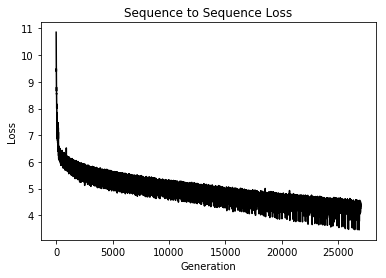

In [17]:


# Plot loss over time
plt.plot(train_loss, 'k-')
plt.title('Sequence to Sequence Loss')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()